In [2]:
import numpy as np
from sklearn.datasets import make_classification
from problexity.classification import f1, n1, clsCoef
from EPCO import EPCO
from ranges import clf_ranges

In [3]:
# Define complexity functions to optimize
complexity_funs = [f1, n1, clsCoef]

# Use function names to otain possible ranges of measures
ranges = [clf_ranges[k.__name__] for k in complexity_funs]
print(ranges)

[[0.2, 0.9], [0.05, 0.3], [0.45, 1.0]]


In [4]:
# Define number of complexity targets -- here: easy, medium, complex
n_targets = 3

# Calculate targets for all complexities
targets = []
for fun_id in range(len(complexity_funs)):
    t = np.linspace(ranges[fun_id][0], ranges[fun_id][1], n_targets)
    targets.append(t)   

targets = np.array(targets).swapaxes(0,1)
print(targets)

[[0.2   0.05  0.45 ]
 [0.55  0.175 0.725]
 [0.9   0.3   1.   ]]


In [5]:
# Generate source data
X_source, y_source = make_classification(n_samples=350, random_state=8166)

# Optimize measures -- select the complex target
gen = EPCO(X_source, y_source, targets[-1], complexity_funs)
gen.generate(iters=50, pop_size=50, cross_ratio=0.2, mut_ratio=0.1, decay=0.007)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


In [18]:
# Fetch resulting datasets
best_f1 = gen.return_best(0)
best_n1 = gen.return_best(1)
best_clsCoef = gen.return_best(2)
best_sum = gen.return_best() # deafult


In [19]:
# Calculate complexities of result datasets

complexities = np.zeros((4,3))
for i, (X, y) in enumerate([best_f1, best_n1, best_clsCoef, best_sum]):
    complexities[i] = [c(X, y) for c in complexity_funs]

print(complexities)

[[0.8753363  0.17714286 0.78021684]
 [0.71857363 0.19142857 0.77678959]
 [0.48296814 0.14857143 0.99285714]
 [0.87497976 0.18       0.78208899]]


In [20]:
# Calculate differences from the target
fitness = np.abs(targets[-1] - complexities)
print(np.round(fitness,3))

[[0.025 0.123 0.22 ]
 [0.181 0.109 0.223]
 [0.417 0.151 0.007]
 [0.025 0.12  0.218]]


In [21]:
# Observations:
# - elemant at (0) i.e. best_f1 has the best fitness in F1 measure (criterion 0)
# - elemant at (1) i.e. best_n1 has the best fitness in N2 measure (criterion 1)
# - element at (2) i.e. best_clsCoef has the best fitness in clsCoef (criterion 2)
# - element at (3) -- default -- i.e. best_sum is trying to find the best solution across all 3 criteria

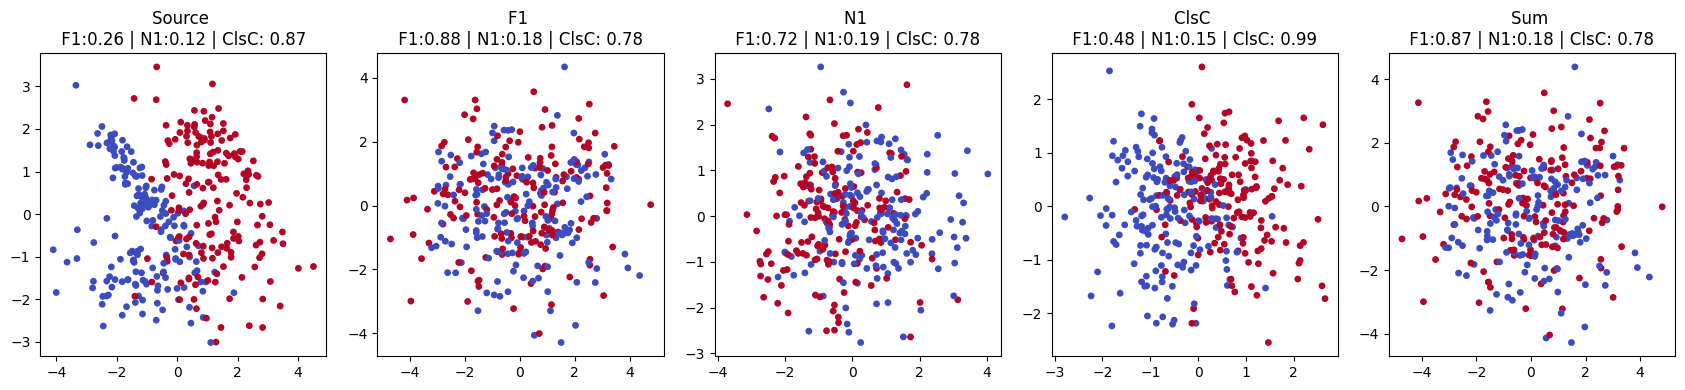

In [22]:
# Plot PCA of source data and obtained data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

labels = ['Source', 'F1', 'N1', 'ClsC', 'Sum']
fig, ax = plt.subplots(1,5,figsize=(17,4))

for i, (X, y) in enumerate([[X_source, y_source], best_f1, best_n1, best_clsCoef, best_sum]):
    pcaX = PCA(n_components=2).fit_transform(X)
    scores = [c(X, y) for c in complexity_funs]
    
    ax[i].scatter(pcaX[:,0], pcaX[:,1], c=y, cmap='coolwarm', s=15)
    ax[i].set_title('%s \n F1:%.2f | N1:%.2f | ClsC: %.2f '% (labels[i], *scores))
    
plt.tight_layout()
plt.savefig('example.png')